## Imports and dependencies

In [1]:
!pip install gdown matplotlib opencv-python

You should consider upgrading via the '/Users/matweykai/Programming/PetProjects/ConstructIO/itmo_ml_sys_project/.venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import random
from pathlib import Path

import cv2
import gdown
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_URL = 'https://drive.google.com/file/d/165VeXLv6_dWK1nVkC5YZ2iuv_BrZDvkV/view?usp=sharing'

In [4]:
gdown.download(DATA_URL, fuzzy=True, quiet=True)

'wall_defects_data.zip'

In [5]:
%%bash
unzip wall_defects_data.zip
mv wall_defects_data* ../data

Archive:  wall_defects_data.zip
   creating: wall_defects_data/
  inflating: wall_defects_data/.DS_Store  
   creating: wall_defects_data/synthetic_data/
  inflating: wall_defects_data/synthetic_data/mold_on_the_walls.png  
  inflating: wall_defects_data/synthetic_data/small_crack_right.png  
  inflating: wall_defects_data/synthetic_data/small_crack_front.png  
  inflating: wall_defects_data/synthetic_data/small_mold_red_wall.png  
  inflating: wall_defects_data/synthetic_data/mold_on_the_walls_2.png  
  inflating: wall_defects_data/synthetic_data/small_cracks_on_the_wall.png  
  inflating: wall_defects_data/synthetic_data/small_crack_front_1.png  
  inflating: wall_defects_data/synthetic_data/small_mold_points_on_walls.png  
  inflating: wall_defects_data/synthetic_data/small_crack_red_wall.png  
  inflating: wall_defects_data/synthetic_data/small_mold_on_left_wall.png  
  inflating: wall_defects_data/synthetic_data/mold_on_walls.png  
   creating: wall_defects_data/positive_samples/


## EDA

Текущий датасет представлен в виде двух наборов данных.
1) Изображения, вырезанные с обзоров ремонтов квартир на Youtube
2) Сгенерированные изображения, которые получены путём наложения на реальные изображения квартир без дефектов плесени и трещин через сервис по генерации изображений

In [6]:
!ls ../data/wall_defects_data/

negative_samples positive_samples synthetic_data


In [7]:
neg_samples_dir = Path('../data/wall_defects_data/negative_samples/')
pos_samples_dir = Path('../data/wall_defects_data/positive_samples/')
synth_samples_dir = Path('../data/wall_defects_data/synthetic_data/')

In [8]:
%%bash
echo "Кол-во изображений из видео:" $(ls -1 ../data/wall_defects_data/positive_samples/ | wc -l)
echo "Кол-во изображений хороших стен:" $(ls -1 ../data/wall_defects_data/negative_samples/ | wc -l)
echo "Кол-во сгенерированных изображений:" $(ls -1 ../data/wall_defects_data/synthetic_data/ | wc -l)

Кол-во изображений из видео: 30
Кол-во изображений хороших стен: 30
Кол-во сгенерированных изображений: 11


In [9]:
def resize_with_pad(image: np.array, new_shape: tuple[int, int], padding_color: tuple[int] = (255, 255, 255)) -> np.array:
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    
    image = cv2.resize(image, new_size)
    
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    
    return image


def show_samples_from_directory(dir_path: Path, samples_grid: tuple[int, int] = (3, 3)):
    random.seed(1234)
    images_path_list = list(dir_path.iterdir())

    samples_count = samples_grid[0] * samples_grid[1]

    plt.figure(figsize=(3 * samples_grid[0], 3 * samples_grid[1]))
    img_size = (160, 160)

    for plt_ind, temp_path in enumerate(random.sample(images_path_list, samples_count), 1):
        plt.subplot(samples_grid[0], samples_grid[1], plt_ind)
        img = cv2.imread(str(temp_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = resize_with_pad(img, img_size)

        plt.imshow(img)
        plt.axis('off')

Как видно на данных изображениях мы видим квартиры после качественного ремонта

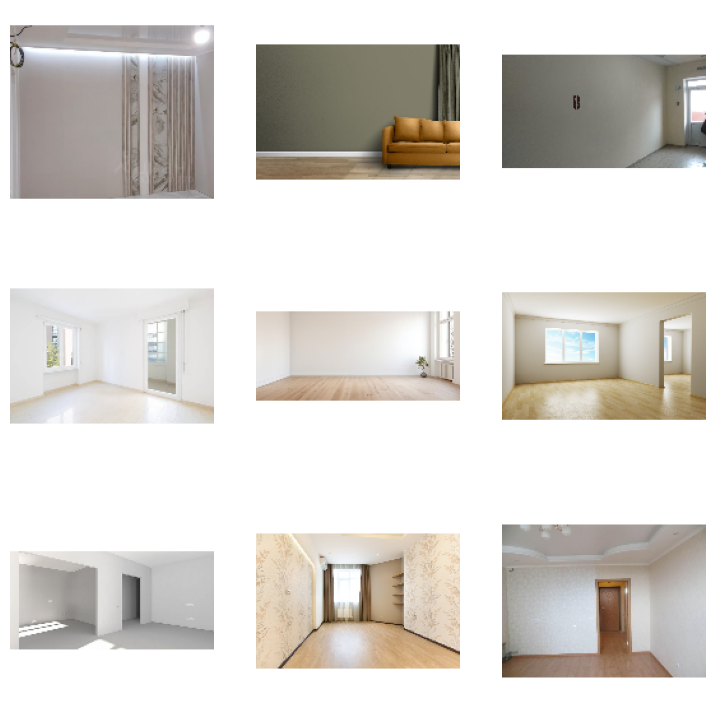

In [10]:
show_samples_from_directory(neg_samples_dir)

Изображения собранные с видеороликов показывают различные дефекты на стенах. Большинство из них снято достаточно близко и на них можно разглядеть дефекты

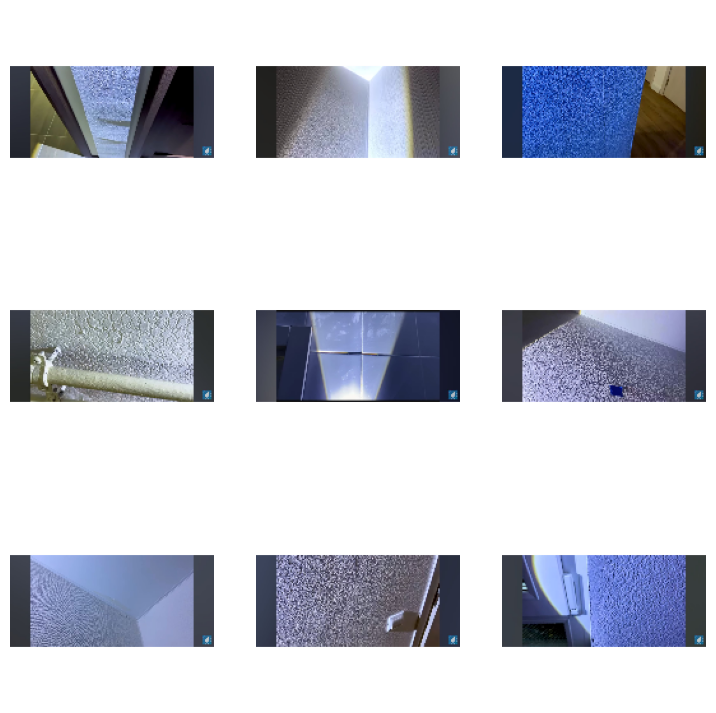

In [11]:
show_samples_from_directory(pos_samples_dir)

Синтетические изображения имеют некоторые артефакты, которые выдают их. Данные изображения получились достаточно вырожденные и отбирались вручную, тк большинство получалось очень нереалистичными.

Данный набор появился в результате проверки гипотезы о том, что нужные нам изображения дефектных стен можно сгенерировать с помощью современных open-source моделей. В результате было выявлено, что это достаточно сложно без дообучения и изображения достаточно сильно отличаются от реальных.

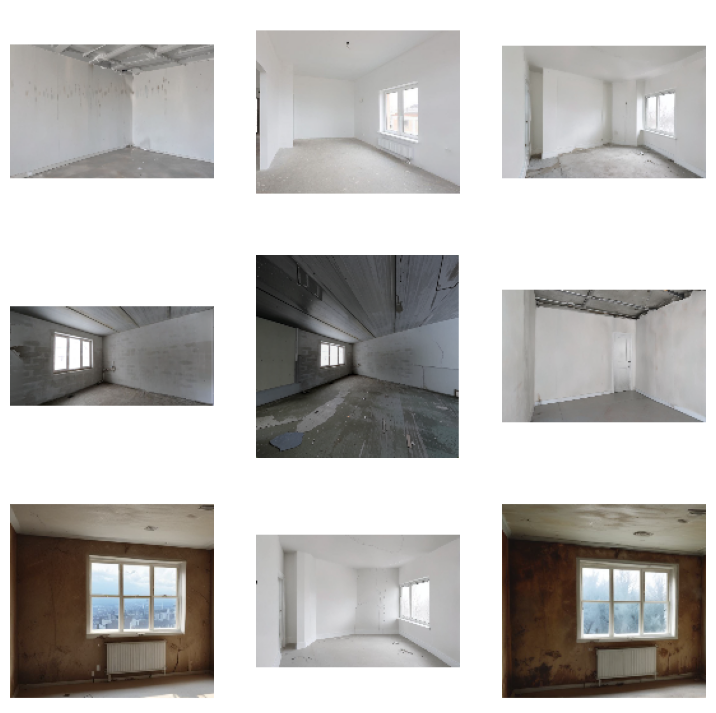

In [12]:
show_samples_from_directory(synth_samples_dir)

In [13]:
positive_samples = list(pos_samples_dir.iterdir())
negative_samples = list(neg_samples_dir.iterdir())

По графику видно, что выборка является сбалансированной, поэтому можно не использовать сложные метрики

<BarContainer object of 2 artists>

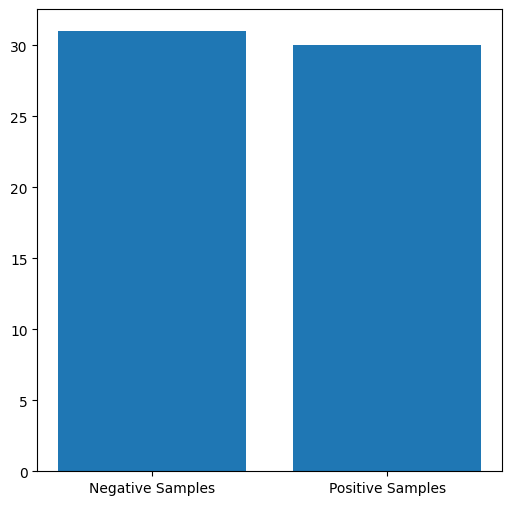

In [14]:
plt.figure(figsize=(6, 6))

plt.bar(['Negative Samples', 'Positive Samples'], [len(negative_samples), len(positive_samples)], )

## Prepocess and split data
Для дальнейших тестов данные должны быть представлены ввиде картинок с расширением .jpg, а также их необходимо поделить на тестовую и валидационную выборки

In [15]:
def copy_data(old_paths_list: list[Path], new_dir: Path):
    for src_path in sorted(old_paths_list):
        if not src_path.name.startswith('.'):
            img = cv2.imread(str(src_path))
            dst_path = new_dir / src_path.name
            cv2.imwrite(str(dst_path), img)

In [16]:
val_size = 10
val_dataset = Path('../data/val_data')
test_dataset = Path('../data/test_data')

In [17]:
# Process val samples
val_neg_paths_list = random.sample(negative_samples, val_size)
val_pos_paths_list = random.sample(positive_samples, val_size)

val_neg_dir = val_dataset / 'negative_samples'
val_pos_dir = val_dataset / 'positive_samples'

val_neg_dir.mkdir(parents=True, exist_ok=True)
val_pos_dir.mkdir(parents=True, exist_ok=True)

copy_data(val_neg_paths_list, val_neg_dir)
copy_data(val_pos_paths_list, val_pos_dir)

# Process test samples
test_neg_paths_list = list(set(negative_samples) - set(val_neg_paths_list))
test_pos_paths_list = list(set(positive_samples) - set(val_pos_paths_list))

test_neg_dir = test_dataset / 'negative_samples'
test_pos_dir = test_dataset / 'positive_samples'

test_neg_dir.mkdir(parents=True, exist_ok=True)
test_pos_dir.mkdir(parents=True, exist_ok=True)

copy_data(test_neg_paths_list, test_neg_dir)
copy_data(test_pos_paths_list, test_pos_dir)